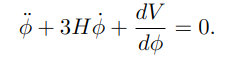

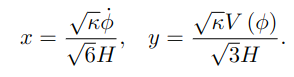

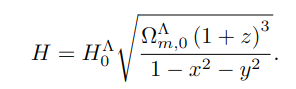

In [270]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
import mplcyberpunk
import tqdm
from functions import nth_derivative

In [271]:
plt.style.use('cyberpunk')
# mplcyberpunk.make_lines_glow()

In [272]:
nodos=50
ANN = nn.Sequential(nn.Linear(1, nodos), nn.Tanh(), nn.Linear(nodos,nodos),
                    #nn.Tanh(), nn.Linear(nodos,nodos),
                    #nn.Tanh(), nn.Linear(nodos,nodos),
                    #nn.Tanh(), nn.Linear(nodos,nodos),
                    # nn.Tanh(), nn.Linear(nodos,nodos),
                    nn.Tanh(),nn.Linear(nodos,2))
print(ANN)

Sequential(
  (0): Linear(in_features=1, out_features=50, bias=True)
  (1): Tanh()
  (2): Linear(in_features=50, out_features=50, bias=True)
  (3): Tanh()
  (4): Linear(in_features=50, out_features=2, bias=True)
)


In [273]:
#The domain and the batch for the training
ti=-2.4 #z=10
tf=0.0 #z=0

t=torch.linspace(ti,tf,1000).view(-1,1)
t.cuda();

In [274]:
#observational data:
datosH=np.loadtxt('datosH.txt')
datosH = torch.Tensor(datosH)
z=datosH[:,0].view(-1,1)
H=datosH[:,1].view(-1,1)

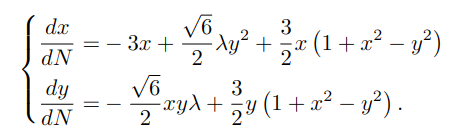

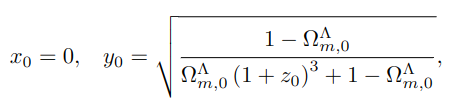

### Real solution

In [275]:
y0=np.sqrt((1-Olm0)/ (Olm0*(1.0+10.0)**3 +1.0 - Olm0))
y0

0.04183300132670378

In [276]:
# Definimos el sistema de ecuaciones
ld=0.008
Olm0=0.3

def f(X,N):
    x,y=X
    Dx = -3*x + 1.22*ld*y**2 + 1.5*x*(1+x**2-y**2)
    Dy = -1.22*ld*x*y + 1.5*y*(1+x**2 - y**2)
    # Combine Dx and Dy into a single array
    return np.array([Dx, Dy])


# Definimos las condiciones iniciales
x0 = 0.0
#y0 = 0.3

# Definimos el intervalo de integración
N_0 = -2.4
N_f = 0

N=np.linspace(N_0,N_f,50)

# Solucionamos la ecuación diferencial
sol = odeint(f, [x0, y0],N)


In [277]:

def cost(t):
    #t0=torch.tensor([[ti]], requires_grad=True)
    z.requires_grad=True

    x=ANN(t)[:,0].view(-1,1)
    y=ANN(t)[:,1].view(-1,1)


    Dx = nth_derivative(ANN,t, 0, 0,1)
    Dy = nth_derivative(ANN,t, 1, 0,1)


    a=torch.mean((Dx + 3*x -1.22*ld*y**2 - 1.5*x*(1+x**2-y**2))**2)
    b=torch.mean((Dy + 1.22*ld*x*y - 1.5*y*(1+x**2 - y**2))**2)

    x_data, y_data=ANN(-torch.log(z+1))[:,0].view(-1,1), ANN(-torch.log(z+1))[:,1].view(-1,1)

    H_quin=67.0*torch.sqrt(Olm0/(1-x_data**2 - y_data**2) * (1+z)**3)
    #h0=ANN(t0)-torch.tensor([[0,y0]])
    h0=H_quin - H
    
    return  a + b + 0.000005*torch.mean(h0**2) 

In [278]:
# ANN(N_data) 
x_data, y_data=ANN(-torch.log(z+1))[:,0].view(-1,1), ANN(-torch.log(z+1))[:,1].view(-1,1)

#H(N)
H_quin=67.0*torch.sqrt(Olm0/(1-x_data**2 - y_data**2) * (1+z)**3)
#h0=ANN(t0)-torch.tensor([[0,y0]])
h0=H_quin - H


In [279]:
cost(t)

tensor(0.0484, grad_fn=<AddBackward0>)

In [280]:
learning_rate=0.01
epocas=5000


optimizer = torch.optim.Adam(ANN.parameters(), lr=learning_rate)

Training: 100%|██████████████████████████████████| 5000/5000 [01:03<00:00, 79.04it/s, loss=0.000786]


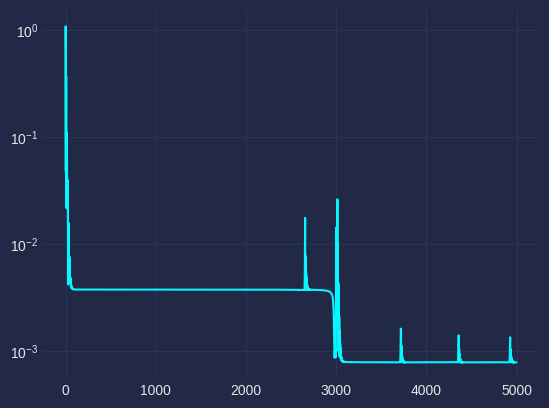

In [281]:
pbar = tqdm.tqdm(range(epocas), desc="Training",  colour='cyan', ncols=100)

errores=[]
for i in pbar:
    l=cost(t) #coste
    #l=torch.nn.MSELoss(Param(T))
    l.backward() #gradiente
    optimizer.step() #se actualizan los parámetros
    optimizer.zero_grad() #vacíamos el gradiente
    #print('época=%.2f , loss=%.2f'%(i,l))
    errores.append(float(l))
    #tqdm.set_description('época: %d , loss: %.2f' % (i, l.item()))
    pbar.set_postfix({'loss': l.item()})
    #pbar.set_refresh(50)
    #tqdm.set_description("Training")
    #print('época=%.2f , loss=%.2f'%(i,l))

plt.plot(range(epocas),errores)
plt.yscale('log')

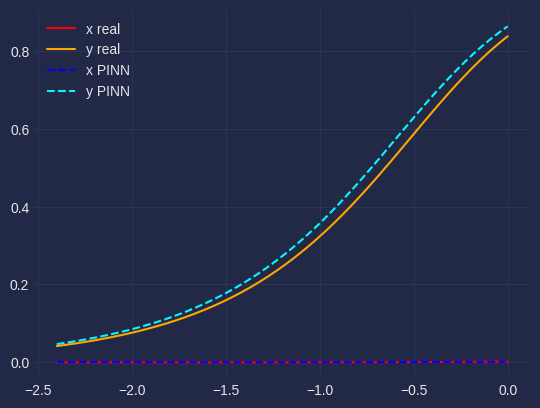

In [289]:
sol_x=ANN(t)[:,0].view(-1,1)
sol_y=ANN(t)[:,1].view(-1,1)
#rhol=ANN(z)[:,2].view(-1,1)
#Hz = 67.0


plt.plot(N,sol[:, 0], label='x real', color='red')
plt.plot(N, sol[:, 1], label='y real', color='orange')
    
plt.plot(t.detach(),sol_x.detach(), '--',label='x PINN', color='blue')
plt.plot(t.detach(),sol_y.detach(), '--', label='y PINN')
plt.legend()

In [283]:
zH=torch.linspace(0.0,3.0,30).view(-1,1)
# sol_x=ANN(-torch.log(zH+1))[:,0].view(-1,1)
# sol_y=ANN(-torch.log(zH+1))[:,1].view(-1,1)
H_quin=67.0*torch.sqrt( Olm0/(1-sol_x**2 - sol_y**2) * torch.exp(-3*t) )

In [284]:
L_data = -torch.log(z+1)
x_data, y_data=ANN(L_data)[:,0].view(-1,1), ANN(L_data)[:,1].view(-1,1)

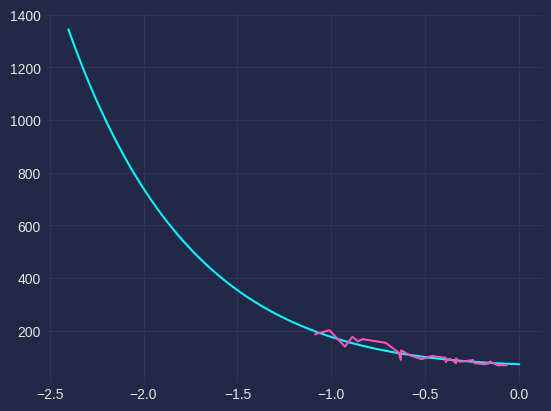

In [285]:
plt.plot(t.detach(),H_quin.detach())
plt.plot(-np.log(z.detach()+1),H)
#plt.xlim(-0.1,0)

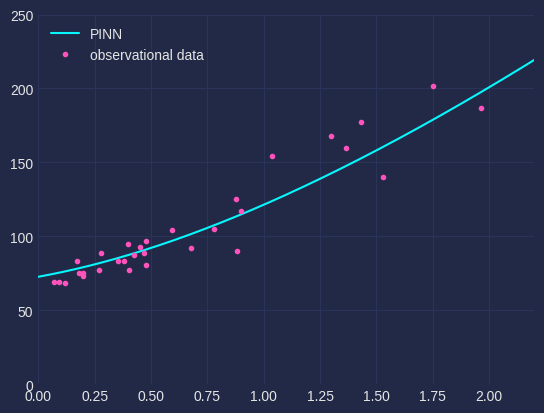

In [286]:
plt.plot(torch.exp(-t).detach()-1.0, H_quin.detach(), label='PINN')
plt.plot(z.detach(),H,'.', label='observational data')
plt.xlim(0,2.2)
plt.ylim(0,250)
plt.legend()

In [290]:
torch.save(ANN.state_dict(),'quintaesencia')

In [288]:
ANN(t[0])

tensor([0.0006, 0.0468], grad_fn=<ViewBackward0>)